## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [33]:
import re

if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616
text = [line.lstrip() for line in text]
text = ''.join(text).lower()
text = re.sub(r'(^|\n)\s*[ivxlcdm]+\s+', '\n', text)

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

### Data loading: "Евгений Онегин"


In [ ]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-12-14 10:03:13--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-12-14 10:03:13 (9.89 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text[0] = ' ' + text[0]
text = ' '.join(text).lower().replace('\n', '')


TypeError: 'str' object does not support item assignment

Put all the characters, that you've seen in the text, into variable `tokens`.

In [34]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [35]:
# dict <index>:<char>
# Your great code here
# Словарь: символ - индекс
token_to_idx = {char: idx for idx, char in enumerate(tokens)}

# Your great code here
#Словарь: индекс - символ
idx_to_char = {idx: char for idx, char in enumerate(tokens)}

print("Tokens:", tokens)
print("Token to index:", token_to_idx)
print("Index to token:", idx_to_char)

Tokens: ['\n', ' ', '!', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Token to index: {'\n': 0, ' ': 1, '!': 2, "'": 3, '(': 4, ')': 5, ',': 6, '-': 7, '.': 8, ':': 9, ';': 10, '?': 11, 'a': 12, 'b': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'g': 18, 'h': 19, 'i': 20, 'j': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'q': 28, 'r': 29, 's': 30, 't': 31, 'u': 32, 'v': 33, 'w': 34, 'x': 35, 'y': 36, 'z': 37}
Index to token: {0: '\n', 1: ' ', 2: '!', 3: "'", 4: '(', 5: ')', 6: ',', 7: '-', 8: '.', 9: ':', 10: ';', 11: '?', 12: 'a', 13: 'b', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'g', 19: 'h', 20: 'i', 21: 'j', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'o', 27: 'p', 28: 'q', 29: 'r', 30: 's', 31: 't', 32: 'u', 33: 'v', 34: 'w', 35: 'x', 36: 'y', 37: 'z'}


*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [36]:
import numpy as np

# размер словаря
vocab_size = len(tokens)

# Преобразование текста в матрицу one-hot encoding
def one_hot_encode(text, vocab_size):
    one_hot_matrix = np.zeros((len(text), vocab_size), dtype=np.float32)
    for i, char in enumerate(text):
      # Заполняем единицей позицию вектора соответствующего символа
        one_hot_matrix[i, token_to_idx[char]] = 1
    return one_hot_matrix

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [37]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Your code here
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(VanillaRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

embedding_size = 64
hidden_size = 128
learning_rate = 0.001
vocab_size = len(tokens)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VanillaRNN(vocab_size, embedding_size, hidden_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [38]:
EPOCHS = 40
BATCH_SIZE = 2048
sequence_length = 100

In [39]:
# Подготовка данных для обучения
class TextDataset(Dataset):
    def __init__(self, text, char_to_idx, seq_len):
        self.text = text
        self.char_to_idx = char_to_idx
        self.seq_len = seq_len
        self.data = [char_to_idx[ch] for ch in text]

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + 1:idx + self.seq_len + 1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

dataset = TextDataset(text, token_to_idx, sequence_length)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [40]:
#Для хранения значения потерь
loss_history = []

#запуск обучения
for epoch in range(EPOCHS):
    hidden = None
    total_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Инициализация скрытого состояния для текущего батча
        hidden = torch.zeros(1, inputs.size(0), hidden_size).to(device)

        optimizer.zero_grad()
        outputs, hidden = model(inputs, hidden)

        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

torch.save(model, 'vRNN.pth')

Epoch [1/40], Loss: 2.8243
Epoch [2/40], Loss: 2.3005
Epoch [3/40], Loss: 2.1225
Epoch [4/40], Loss: 2.0081
Epoch [5/40], Loss: 1.9180
Epoch [6/40], Loss: 1.8458
Epoch [7/40], Loss: 1.7873
Epoch [8/40], Loss: 1.7392
Epoch [9/40], Loss: 1.6987
Epoch [10/40], Loss: 1.6637
Epoch [11/40], Loss: 1.6324
Epoch [12/40], Loss: 1.6041
Epoch [13/40], Loss: 1.5784
Epoch [14/40], Loss: 1.5549
Epoch [15/40], Loss: 1.5333
Epoch [16/40], Loss: 1.5132
Epoch [17/40], Loss: 1.4944
Epoch [18/40], Loss: 1.4767
Epoch [19/40], Loss: 1.4603
Epoch [20/40], Loss: 1.4451
Epoch [21/40], Loss: 1.4306
Epoch [22/40], Loss: 1.4172
Epoch [23/40], Loss: 1.4044
Epoch [24/40], Loss: 1.3923
Epoch [25/40], Loss: 1.3809
Epoch [26/40], Loss: 1.3701
Epoch [27/40], Loss: 1.3598
Epoch [28/40], Loss: 1.3500
Epoch [29/40], Loss: 1.3408
Epoch [30/40], Loss: 1.3321
Epoch [31/40], Loss: 1.3240
Epoch [32/40], Loss: 1.3164
Epoch [33/40], Loss: 1.3093
Epoch [34/40], Loss: 1.3031
Epoch [35/40], Loss: 1.2972
Epoch [36/40], Loss: 1.2920
E

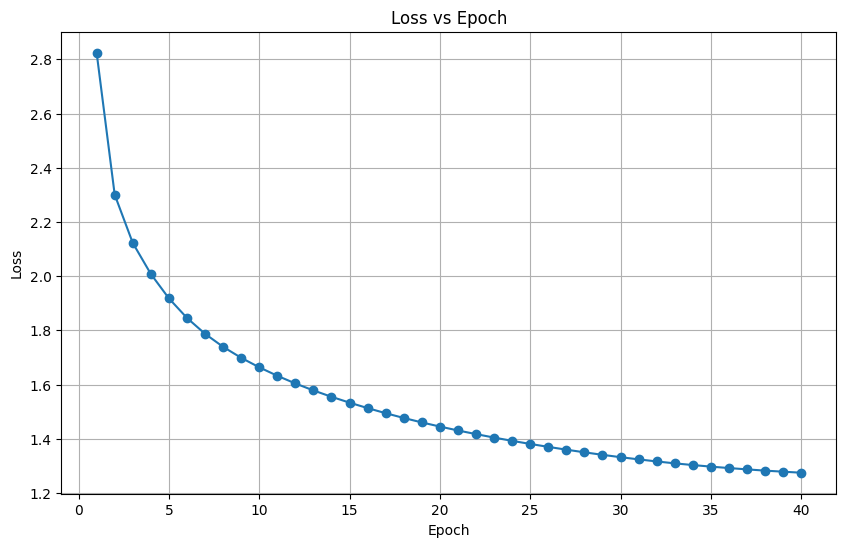

In [41]:
# Your plot code here
import matplotlib.pyplot as plt

# Визуализация функции потерь
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), loss_history, marker='o')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

In [42]:
model = torch.load('vRNN.pth', weights_only=False)

In [43]:
import torch.nn.functional as F

def generate_text(model, start_text, length, temperature = 1.0):
    model.eval()
    input_text = torch.tensor([token_to_idx[ch] for ch in start_text], dtype=torch.long).unsqueeze(0).to(device)
    hidden = None
    generated_text = start_text.lower()

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_text, hidden)
            next_char_idx = torch.argmax(output[:, -1, :]).item()
            next_char = idx_to_char[next_char_idx]
            generated_text += next_char
            input_text = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return generated_text

In [44]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

start_text = "the cat goes home on friday"  # Replace with your own starting sequence
print(generate_text(model, start_text, 500, 0.2))

the cat goes home on friday would the lovely desired,
and the world i are but in the stars with the worth the world and see thee is thing they see assead,
the world with this live i am fortune to thee shall be this thoughts one i so still doth for my soul the world shall be the there is my love's desire to moth to gracious the star the strength so summer's good of the world shall be the there is my love's desire to moth to gracious the star the strength so summer's good of the world shall be the there is my love's desire 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [45]:
# Your beautiful code here
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

In [46]:
# Инициализация LSTM model
lstm_model = LSTMModel(vocab_size, embedding_size, hidden_size).to(device)

# Функция потерь и optimizer для LSTM
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

# Для хранения функции потерь
lstm_loss_history = []
# запуск обучения для LSTM
for epoch in range(EPOCHS):
    total_loss = 0

    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        batch_size = inputs.size(0)

        hidden = (torch.zeros(1, batch_size, hidden_size).to(device),
              torch.zeros(1, batch_size, hidden_size).to(device))  # LSTM hidden state (h, c)

        if hidden is None or hidden[0].size(1) != batch_size:
            # Повторно инициализируйте скрытое состояние, если это первый пакет или изменяется размер пакета
            hidden = (
                torch.zeros(1, batch_size, hidden_size).to(device),
                torch.zeros(1, batch_size, hidden_size).to(device)
            )
        else:
            # Detach скрытого состояния от графика вычислений, чтобы предотвратить повторный просмотр истории
            hidden = tuple(h.detach() for h in hidden)


        optimizer.zero_grad()
        outputs, hidden = lstm_model(inputs, hidden)
        hidden = tuple([h.detach() for h in hidden])  # Detach скрытого состояния, чтобы предотвратить повторный просмотр истории

        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    lstm_loss_history.append(avg_loss)
    print(f"LSTM Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}")

LSTM Epoch [1/40], Loss: 3.0241
LSTM Epoch [2/40], Loss: 2.4131
LSTM Epoch [3/40], Loss: 2.1873
LSTM Epoch [4/40], Loss: 2.0402
LSTM Epoch [5/40], Loss: 1.9366
LSTM Epoch [6/40], Loss: 1.8584
LSTM Epoch [7/40], Loss: 1.7959
LSTM Epoch [8/40], Loss: 1.7439
LSTM Epoch [9/40], Loss: 1.7002
LSTM Epoch [10/40], Loss: 1.6624
LSTM Epoch [11/40], Loss: 1.6286
LSTM Epoch [12/40], Loss: 1.5978
LSTM Epoch [13/40], Loss: 1.5694
LSTM Epoch [14/40], Loss: 1.5430
LSTM Epoch [15/40], Loss: 1.5181
LSTM Epoch [16/40], Loss: 1.4945
LSTM Epoch [17/40], Loss: 1.4720
LSTM Epoch [18/40], Loss: 1.4504
LSTM Epoch [19/40], Loss: 1.4298
LSTM Epoch [20/40], Loss: 1.4098
LSTM Epoch [21/40], Loss: 1.3904
LSTM Epoch [22/40], Loss: 1.3718
LSTM Epoch [23/40], Loss: 1.3535
LSTM Epoch [24/40], Loss: 1.3356
LSTM Epoch [25/40], Loss: 1.3180
LSTM Epoch [26/40], Loss: 1.3005
LSTM Epoch [27/40], Loss: 1.2837
LSTM Epoch [28/40], Loss: 1.2668
LSTM Epoch [29/40], Loss: 1.2504
LSTM Epoch [30/40], Loss: 1.2343
LSTM Epoch [31/40],

In [47]:
torch.save(model, 'LTSM.pth')

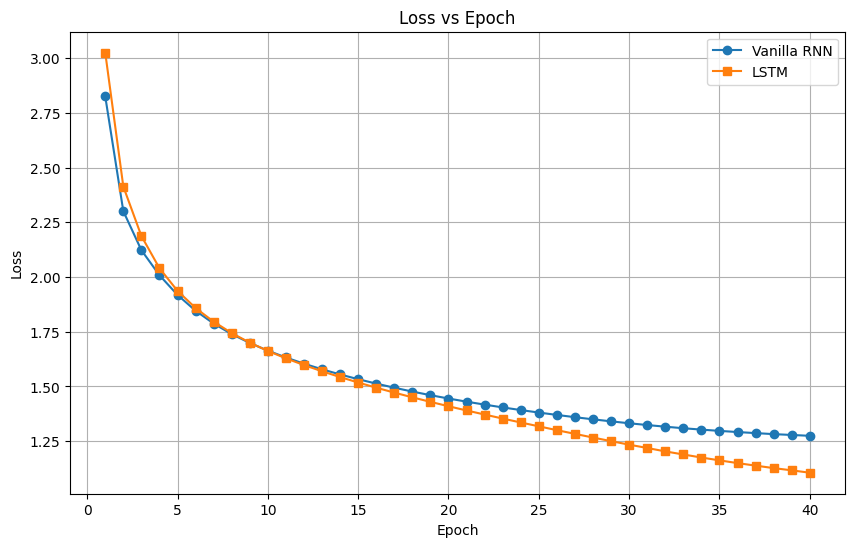

In [48]:
import matplotlib.pyplot as plt
# Визуализация функции потерь для Vanilla RNN и LSTM
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), loss_history, marker='o', label='Vanilla RNN')
plt.plot(range(1, EPOCHS + 1), lstm_loss_history, marker='s', label='LSTM')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Vanilla RNN:

1) Страдает от проблемы затухающих или взрывающихся градиентов, из-за чего плохо обучается на длинных последовательностях.

2) Ограничена в моделировании долгосрочных зависимостей.

# LSTM:

1) Решает проблему затухающих градиентов благодаря механизму гейтов и прямому переносу информации через ячейки памяти.

2) Эффективно работает с длинными последовательностями.

# Скорость вычислений и ресурсы:

1) Vanilla RNN:

Легче и быстрее обучается, так как у нее меньше параметров и простая структура.
Подходит для задач, где важна скорость и последовательности короткие.

2) LSTM:

Более ресурсоемкая из-за сложной структуры (гейты, ячейки памяти).
Замедляется на больших наборах данных, но часто оправдана для сложных задач.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [49]:
import torch.nn.functional as F
# Функция для генерации текста с различными значениями temperature
def generate_text_with_temperature(model, start_text, length, temperature):
    model.eval()
    input_text = torch.tensor([token_to_idx[ch] for ch in start_text], dtype=torch.long).unsqueeze(0).to(device)
    hidden = (torch.zeros(1, 1, hidden_size).to(device), torch.zeros(1, 1, hidden_size).to(device))  # For LSTM
    generated_text = start_text

    with torch.no_grad():
        for _ in range(length):
            output, hidden = model(input_text, hidden)
            output = output[:, -1, :]  # Focus на последнем символе в последовательности

            # масштабирование temperature
            scaled_logits = output / temperature
            probabilities = F.softmax(scaled_logits, dim=-1).cpu().numpy().flatten()

            # Нормализация вероятности (при необходимости) и выбор следующего символа
            probabilities /= probabilities.sum()
            next_char_idx = np.random.choice(len(probabilities), p=probabilities)
            next_char = idx_to_char[next_char_idx]

            generated_text += next_char
            input_text = torch.tensor([[next_char_idx]], dtype=torch.long).to(device)

    return generated_text

In [50]:
start_text = "to be or not to be"
length = 200  # Длина генерируемого текста

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"--- Temperature: {temp} ---")
    generated_text = generate_text_with_temperature(lstm_model, start_text, length, temp)
    print(generated_text)
    print("\n")

--- Temperature: 0.1 ---
to be or not to be so, nor then thou art as the breath that thou art and there be there eyes of state,
and therefore thy shadow sight,
and spent,
that thou thy self are you will be the true,
and thee for my self alone,


--- Temperature: 0.2 ---
to be or not to be so, nor that which i have sweet to the searn's fair should but the right of the world will to the sweet stand and of all the world will one of all the wirther of the seal of thy sight,
shall to the w


--- Temperature: 0.5 ---
to be or not to be such stays thee is blood sweet love doth work,
the onceigh', or i love believe,
thou let me still lose the tongue:
on me to see thee from the hearth to more of well by done, but mayst thou thy sing.



--- Temperature: 1.0 ---
to be or not to be so longer 'igncears, and lost i can nature plays let the woubding dead so enduate;
sent like thou hast thou despite and thee receives thee,
lest your made or thy say.
to since new as fading nefuled y


--- Temperature:

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [53]:
# Saving and loading code here
torch.save(model, 'model.pth')
print('Модель сохранена в файл: model.pth')

# Загрузка модели
model_loaded = torch.load('model.pth', weights_only=False)
model_loaded.eval()  # Переводим модель в режим оценки
print('Модель загружена и переведена в режим оценки')
print()
# Генерация текста загруженной моделью
seed_text = "to be or not to be"
print(generate_text_with_temperature(model, seed_text, length=200, temperature=0.5))

Модель сохранена в файл: model.pth
Модель загружена и переведена в режим оценки



"to be or not to be time's still this thy seew,\nbeing thy own what love, and this all is thy good have sweet with thine eye is in the face,\nseeful so storn on the worstance unfairs, the lay still desired the self in giv"

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)